<a href="https://colab.research.google.com/github/strna8/healthcare-news-crawling-analysis/blob/main/news_data_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
네이버 뉴스 크롤링 - Healthcare Trend 분석
키워드: 디지털 헬스케어, 원격의료, AI 의료
"""

# ================================
# 1. 라이브러리 설치 및 임포트
# ================================
!pip install -q requests pandas matplotlib seaborn konlpy

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime, timedelta
import re
from konlpy.tag import Okt

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

print("✅ 준비 완료!\n")

# ================================
# 2. API 설정
# ================================
CLIENT_ID = "****************"
CLIENT_SECRET = "*************"

# ================================
# 3. 뉴스 수집 함수
# ================================
def collect_news(keyword, days=7, display=100):
    """
    네이버 뉴스 수집

    Parameters:
    - keyword: 검색 키워드
    - days: 수집 기간 (일)
    - display: 한 번에 가져올 개수
    """

    url = "https://openapi.naver.com/v1/search/news.json"

    headers = {
        "X-Naver-Client-Id": CLIENT_ID,
        "X-Naver-Client-Secret": CLIENT_SECRET
    }

    all_news = []

    print(f"🔍 '{keyword}' 뉴스 수집 시작...")
    print(f"📅 최근 {days}일 데이터 수집 중...\n")

    # 날짜 필터링을 위한 기준일
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days)

    # 페이지별 수집 (최대 100개씩)
    for start in range(1, 1001, display):  # 최대 1000개

        params = {
            "query": keyword,
            "display": display,
            "start": start,
            "sort": "date"  # 최신순
        }

        try:
            response = requests.get(url, headers=headers, params=params)

            if response.status_code == 200:
                data = response.json()
                items = data.get('items', [])

                if not items:  # 더 이상 데이터 없으면 종료
                    break

                for item in items:
                    # HTML 태그 제거
                    title = item['title'].replace('<b>', '').replace('</b>', '')
                    title = title.replace('&quot;', '"').replace('&apos;', "'")

                    # 날짜 파싱
                    pub_date_str = item['pubDate']
                    # 'Mon, 21 Oct 2024 10:30:00 +0900' 형식
                    pub_date = datetime.strptime(pub_date_str, '%a, %d %b %Y %H:%M:%S %z')
                    pub_date = pub_date.replace(tzinfo=None)  # timezone 제거

                    # 날짜 필터링
                    if pub_date < start_date:
                        continue

                    # 언론사 추출 (링크에서)
                    link = item['link']
                    media = extract_media_from_link(link)

                    all_news.append({
                        'title': title,
                        'date': pub_date.strftime('%Y-%m-%d'),
                        'datetime': pub_date,
                        'media': media,
                        'link': link
                    })

                print(f"  페이지 {start//display + 1}: {len(items)}개 수집")

            else:
                print(f"❌ API 오류: {response.status_code}")
                break

        except Exception as e:
            print(f"❌ 오류: {e}")
            break

    df = pd.DataFrame(all_news)

    # 중복 제거
    df = df.drop_duplicates(subset='title')

    # 날짜순 정렬
    df = df.sort_values('datetime', ascending=False)

    print(f"\n✅ 총 {len(df)}개 뉴스 수집 완료!")

    return df

# ================================
# 4. 언론사 추출 함수
# ================================
def extract_media_from_link(link):
    """링크에서 언론사 이름 추출"""

    media_mapping = {
        'chosun.com': '조선일보',
        'joins.com': '중앙일보',
        'donga.com': '동아일보',
        'khan.co.kr': '경향신문',
        'hani.co.kr': '한겨레',
        'mk.co.kr': '매일경제',
        'sedaily.com': '서울경제',
        'hankyung.com': '한국경제',
        'mt.co.kr': '머니투데이',
        'yna.co.kr': '연합뉴스',
        'ytn.co.kr': 'YTN',
        'kbs.co.kr': 'KBS',
        'sbs.co.kr': 'SBS',
        'mbc.co.kr': 'MBC',
        'newsis.com': '뉴시스',
        'news1.kr': '뉴스1',
        'ajunews.com': '아주경제',
        'biz.chosun.com': '조선비즈',
    }

    for domain, name in media_mapping.items():
        if domain in link:
            return name

    # 매핑되지 않은 경우 도메인에서 추출
    try:
        domain = link.split('//')[1].split('/')[0]
        return domain.replace('www.', '').split('.')[0]
    except:
        return '기타'

# ================================
# 5. 키워드별 수집 실행
# ================================
print("="*60)
print("🏥 Healthcare Trend 뉴스 수집")
print("="*60 + "\n")

# 여러 키워드 수집
keywords = ["디지털헬스케어", "원격의료", "AI의료"]

all_df = pd.DataFrame()

for keyword in keywords:
    print(f"\n{'='*60}")
    print(f"키워드: {keyword}")
    print('='*60)

    df = collect_news(keyword, days=7, display=100)
    all_df = pd.concat([all_df, df], ignore_index=True)

    print(f"\n현재까지 수집: {len(all_df)}개")

# 최종 중복 제거
all_df = all_df.drop_duplicates(subset='title')
all_df = all_df.sort_values('datetime', ascending=False).reset_index(drop=True)

print(f"\n{'='*60}")
print(f"✅ 최종 수집 완료: {len(all_df)}개 기사")
print('='*60)

# 샘플 출력
print("\n📋 수집된 기사 샘플 (최근 10개):")
print("-"*60)
for i, row in all_df.head(10).iterrows():
    print(f"{i+1}. [{row['date']}] {row['media']} - {row['title'][:60]}...")

# 저장
all_df.to_csv('healthcare_news.csv', index=False, encoding='utf-8-sig')
print("\n💾 'healthcare_news.csv' 저장 완료!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 14.0 MB/s eta 0:00:00
✅ 준비 완료!

🏥 Healthcare Trend 뉴스 수집


키워드: 디지털헬스케어
🔍 '디지털헬스케어' 뉴스 수집 시작...
📅 최근 7일 데이터 수집 중...

  페이지 1: 100개 수집
  페이지 2: 100개 수집
  페이지 3: 100개 수집
  페이지 4: 100개 수집
  페이지 5: 100개 수집
  페이지 6: 100개 수집
  페이지 7: 100개 수집
  페이지 8: 100개 수집
  페이지 9: 100개 수집
  페이지 10: 100개 수집

✅ 총 926개 뉴스 수집 완료!

현재까지 수집: 926개

키워드: 원격의료
🔍 '원격의료' 뉴스 수집 시작...
📅 최근 7일 데이터 수집 중...

  페이지 1: 100개 수집
  페이지 2: 100개 수집
  페이지 3: 100개 수집
  페이지 4: 100개 수집
  페이지 5: 100개 수집
  페이지 6: 100개 수집
  페이지 7: 100개 수집
  페이지 8: 100개 수집
  페이지 9: 100개 수집
  페이지 10: 100개 수집

✅ 총 120개 뉴스 수집 완료!

현재까지 수집: 1046개

키워드: AI의료
🔍 'AI의료' 뉴스 수집 시작...
📅 최근 7일 데이터 수집 중...

  페이지 1: 100개 수집
  페이지 2: 100개 수집
  페이지 3: 100개 수집
  페이지 4: 100개 수집
  페이지 5: 100개 수집
  페이지 6: 100개 수집
  페이지 7: 100개 수집
  페이지 8: 100개 수집
  페이지 9: 100개 수집
  페이지 10: 100개 수집

✅ 총 925개 뉴스 수집 완료!

현재까지 수집: 1971개

✅ 최종 수집 완료: 1744개 

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ 한글 폰트 설정 완료!

📊 분석 데이터: 1744개 기사
📅 기간: 2025-10-14 00:00:00 ~ 2025-10-21 00:00:00
📰 언론사 수: 336개

📅 일자별 기사 수
      date  count
2025-10-14      8
2025-10-15     10
2025-10-16     90
2025-10-17    366
2025-10-18     31
2025-10-19     71
2025-10-20    437
2025-10-21    731


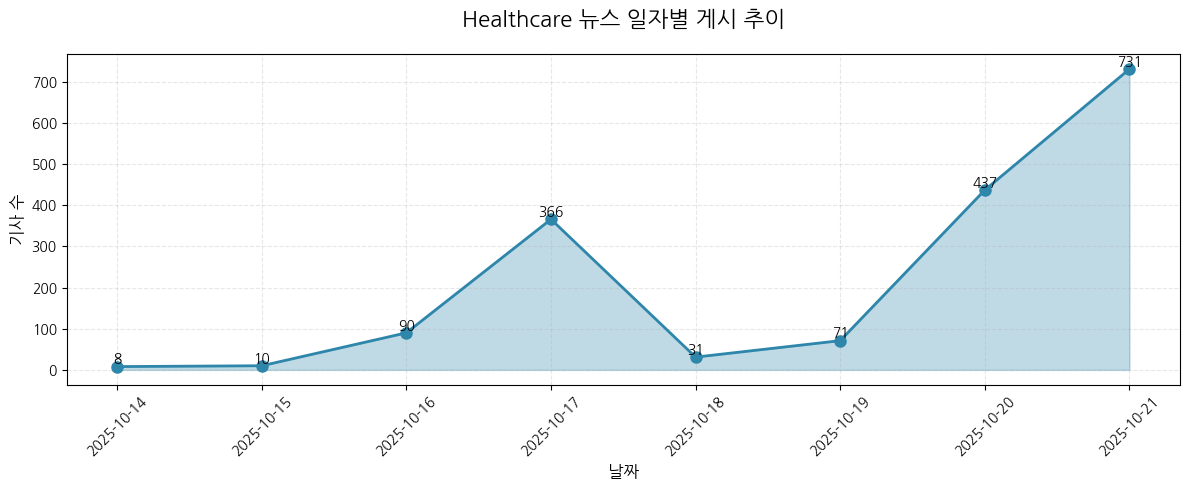


📰 언론사별 기사 수 TOP 10
media
n               487
news             25
newspim          20
kukinews         17
thebell          17
bosa             17
etoday           16
daily            15
pinpointnews     15
yakup            14


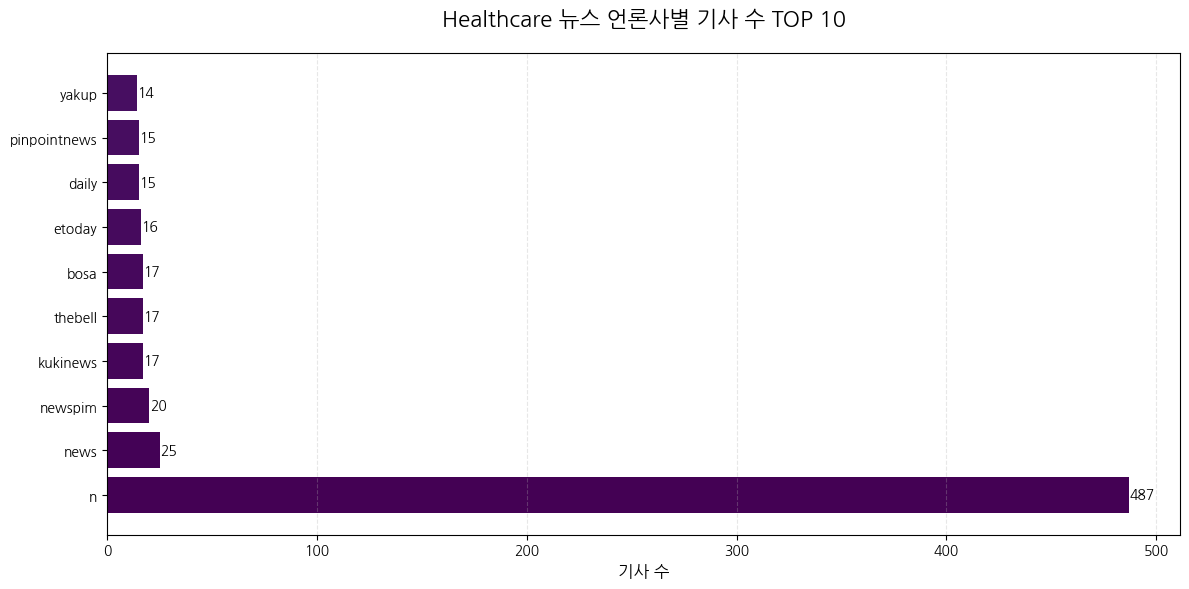


🔤 제목에서 가장 많이 등장한 단어 TOP 20

순위  단어          빈도
------------------------------
 1.   삼성          269회
 2.   투자          200회
 3.   스케          171회
 4.   바이오         161회
 5.   기업          151회
 6.   레일          142회
 7.   진단          136회
 8.   의료          133회
 9.   혁신          120회
10.   전자          113회
11.   디지털         110회
12.   기술          107회
13.   조기          106회
14.   개최           95회
15.   물산           93회
16.   글로벌          88회
17.   병원           77회
18.   대구시          71회
19.   혈액           71회
20.   산업           64회


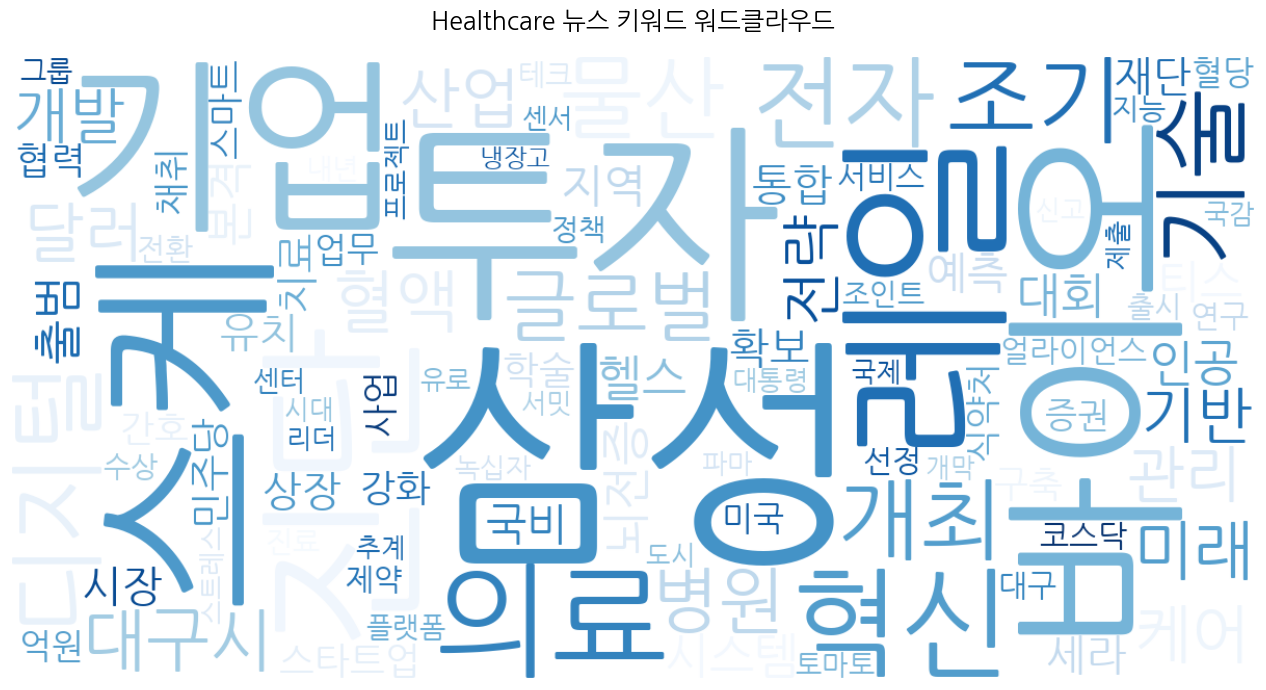


✅ 분석 완료!


In [3]:
"""
Healthcare 뉴스 데이터 분석
"""

# ================================
# 0. 한글 폰트 설정 (Colab 환경)
# ================================
# Colab 환경에서 나눔 폰트 설치 및 캐시 업데이트
!apt-get update -qq
!apt-get install fonts-nanum -qq > /dev/null

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(fontpath)
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

print("✅ 한글 폰트 설정 완료!\n")


# ================================
# 1. 데이터 로드
# ================================
df = pd.read_csv('healthcare_news.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"📊 분석 데이터: {len(df)}개 기사")
print(f"📅 기간: {df['date'].min()} ~ {df['date'].max()}")
print(f"📰 언론사 수: {df['media'].nunique()}개\n")

# ================================
# 2. 일자별 기사 수 집계
# ================================
print("="*60)
print("📅 일자별 기사 수")
print("="*60)

daily_count = df.groupby('date').size().reset_index(name='count')
daily_count = daily_count.sort_values('date')

print(daily_count.to_string(index=False))

# 시각화
plt.figure(figsize=(12, 5))
plt.plot(daily_count['date'], daily_count['count'],
         marker='o', linewidth=2, markersize=8, color='#2E86AB')
plt.fill_between(daily_count['date'], daily_count['count'], alpha=0.3, color='#2E86AB')

plt.title('Healthcare 뉴스 일자별 게시 추이', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('기사 수', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45)

# 각 점에 숫자 표시
for i, row in daily_count.iterrows():
    plt.text(row['date'], row['count'] + 0.5, str(row['count']),
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('daily_count.png', dpi=300, bbox_inches='tight')
plt.show()

# ================================
# 3. 언론사별 기사 수 TOP 10
# ================================
print("\n" + "="*60)
print("📰 언론사별 기사 수 TOP 10")
print("="*60)

media_count = df['media'].value_counts().head(10)
print(media_count.to_string())

# 시각화
plt.figure(figsize=(12, 6))
bars = plt.barh(range(len(media_count)), media_count.values,
                color=plt.cm.viridis(range(len(media_count))))

plt.yticks(range(len(media_count)), media_count.index)
plt.xlabel('기사 수', fontsize=12, fontweight='bold')
plt.title('Healthcare 뉴스 언론사별 기사 수 TOP 10',
          fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3, linestyle='--')

# 막대 끝에 숫자 표시
for i, (idx, val) in enumerate(media_count.items()):
    plt.text(val + 0.3, i, str(val),
             va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('media_top10.png', dpi=300, bbox_inches='tight')
plt.show()

# ================================
# 4. 제목 키워드 분석 (TOP 20)
# ================================
print("\n" + "="*60)
print("🔤 제목에서 가장 많이 등장한 단어 TOP 20")
print("="*60)

# 텍스트 전처리
okt = Okt()

def extract_nouns(text):
    """명사 추출 및 불용어 제거"""
    # 특수문자 제거
    text = re.sub(r'[^가-힣\s]', ' ', str(text))

    # 명사 추출
    nouns = okt.nouns(text)

    # 불용어 제거
    stopwords = {
        '기자', '뉴스', '오늘', '어제', '내일', '올해', '지난', '이날',
        '관련', '대한', '통해', '위해', '등', '및', '매일', '데일리',
        '타임즈', '경제', '조선', '중앙', '동아', '한국', '서울'
    }

    # 2글자 이상, 불용어 제외
    nouns = [n for n in nouns if len(n) > 1 and n not in stopwords]

    return nouns

# 모든 제목에서 명사 추출
all_words = []
for title in df['title']:
    all_words.extend(extract_nouns(title))

# 빈도 계산
word_counts = Counter(all_words)
top20 = word_counts.most_common(20)

print("\n순위  단어          빈도")
print("-" * 30)
for i, (word, count) in enumerate(top20, 1):
    print(f"{i:2d}.   {word:10s}  {count:3d}회")

# 워드클라우드
from wordcloud import WordCloud

wc = WordCloud(
    font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    width=1200,
    height=600,
    background_color='white',
    colormap='Blues',
    max_words=100
).generate_from_frequencies(word_counts)

plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Healthcare 뉴스 키워드 워드클라우드',
          fontsize=18, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('wordcloud.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ 분석 완료!")